In [22]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
root = "/content/drive/MyDrive/Colab_Notebooks/Anamoly/CV-Image-Assignment/train/"
defect_folder = os.path.join(root, "defect")
non_defect_folder = os.path.join(root, "normal")

In [25]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return images
def preprocess_data(defect_folder, nodefect_folder):
    defect_images = load_images_from_folder(defect_folder)
    nodefect_images = load_images_from_folder(nodefect_folder)
    # print(len(defect_images))
    # print(len(nodefect_images))


    # augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip=False,
        brightness_range=[0.8, 1.2]
    )
    augmented_images = []
    for img in defect_images:
        augmented_images.append(img)
        img = np.expand_dims(img, axis=0)
        it = datagen.flow(img, batch_size=1)
        for _ in range(2):  # 4 augmented images per original image
            batch = it.next()
            augmented_img = batch[0].astype('float32')
            augmented_images.append(augmented_img)

    # combine defect and non-defect images
    X = np.concatenate((augmented_images, nodefect_images))
    y = np.concatenate((np.ones(len(augmented_images)), np.zeros(len(nodefect_images))))

    # shuffle
    X, y = shuffle(X, y, random_state=57)
    return X, y

In [26]:
X, y = preprocess_data(defect_folder, non_defect_folder)
# print(len(X))
# print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)


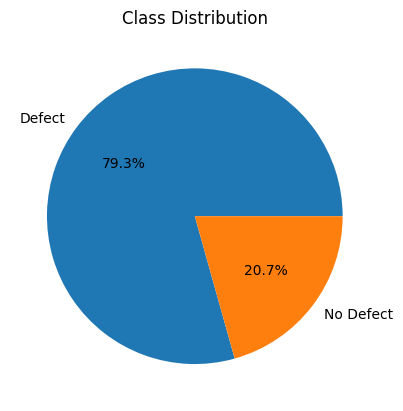

In [27]:
def plot_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    labels = ['Defect', 'No Defect']
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution')
    plt.show()
plot_class_distribution(y_train, "before_smote")


146


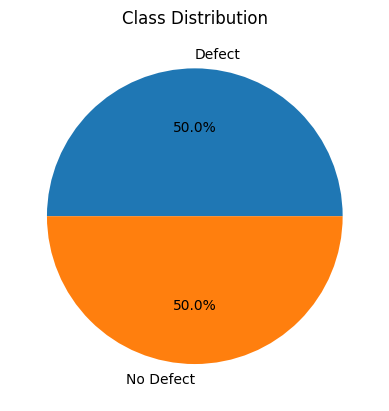

In [28]:
smote = SMOTE(random_state=57)
X_train, y_train = smote.fit_resample(X_train.reshape(-1, 224 * 224 * 3), y_train)

X_train = X_train.reshape(-1, 224, 224, 3)
print(len(X_train))
plot_class_distribution(y_train, "after_smote")


In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers

def create_model_resnet():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

resnet_model = create_model_resnet()

resnet_model.summary()


resnet_model.compile(optimizer=Adam(lr=0.00001),
                     loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [31]:
class_weight = {0: 1, 1: 1}
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)
history = resnet_model.fit(X_train, y_train, epochs=20, batch_size=16,
                            validation_data=(X_test, y_test),
                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True), reduce_lr])
resnet_model.save(root + "resnet_2.h5")

Epoch 1/20
10/10 [==============================] - 10s 227ms/step - loss: 13.3987 - accuracy: 0.8562 - val_loss: 13.8233 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 1s 68ms/step - loss: 12.4995 - accuracy: 1.0000 - val_loss: 12.9614 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 1s 82ms/step - loss: 11.6391 - accuracy: 0.9932 - val_loss: 11.8874 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 1s 68ms/step - loss: 10.6783 - accuracy: 0.9726 - val_loss: 10.9258 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 1s 77ms/step - loss: 9.8567 - accuracy: 0.9795 - val_loss: 9.9438 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 1s 83ms/step - loss: 9.1828 - accuracy: 0.9863 - val_loss: 9.2672 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 1s 76ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


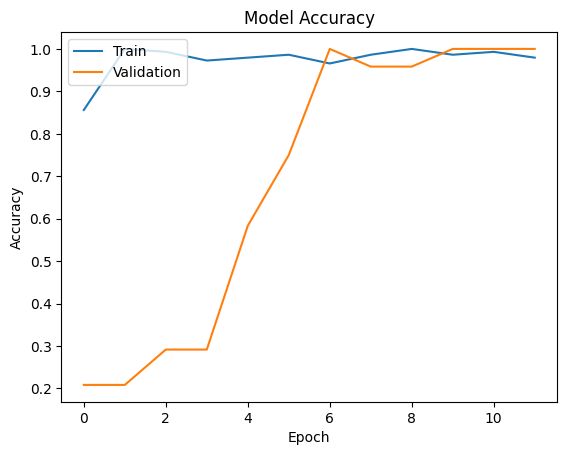

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

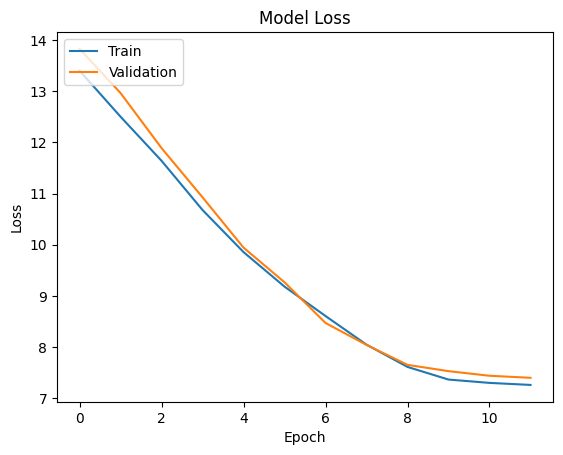

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = resnet_model.predict(X_test)
y_pred = np.round(y_pred).flatten()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [35]:
savedModel=tf.keras.models.load_model(root + "resnet_2.h5")
savedModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = savedModel.predict(X_test)
y_pred = np.round(y_pred).flatten()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [37]:
defect_images = load_images_from_folder(defect_folder)
new_def = []
y_pred = savedModel.predict(np.array(defect_images))
y_pred = np.round(y_pred).flatten()
def_y_test = np.ones(len(y_pred))
precision = precision_score(def_y_test, y_pred)
recall = recall_score(def_y_test, y_pred)
f1 = f1_score(def_y_test, y_pred)
report = classification_report(def_y_test, y_pred)
print(report)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

